In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import vectorbt as vbt
from core.data_loader import DataLoader
import os
import sys
from core.backtester import Backtester
from strategies.atr_breakout import ATRTrailingBreakout
from strategies.multi_momentum import MultiTimeframeMomentum
from strategies.vwap_reversion import VWAPReversion
from strategies.bb_rsi import BB_RSI
import logging
from datetime import datetime
import pandas as pd
import numpy as np
import pandas as pd
import vectorbt as vbt
import yfinance as yf
from matplotlib import pyplot as plt

In [2]:
# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Завантаження даних
loader = DataLoader()
data_file = 'sol_1h_mrhapr25_askbid.parquet'
if os.path.exists(os.path.join('data', data_file)):
    logger.info("Завантаження даних...")
    # dfh = loader.fetch_historical_bid_ask('SOLBTC', '1h', start_date='2025-03-01', end_date='2025-05-01')
    
    end_date = (datetime.now() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    start_date = (datetime.now() - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    df = loader.fetch_historical_bid_ask('SOLBTC', '1h', start_date=start_date, end_date=end_date)
    loader.save_data({'SOLBTC': df}, data_file)
else:
    df = loader.load_data(data_file, '1h')
    df = df['SOLBTC']
data = df['close']
symbol = 'SOLBTC'
df
split_point = len(df) // 2
test_df = df.iloc[split_point:]
df = df.iloc[:split_point]
test_df

INFO:__main__:Завантаження даних...


,open,high,low,close,volume,bid,ask
timestamp,,,,,,,
2025-04-01 16:00:00,0.001516,0.001516,0.001507,0.001507,7093.651,0.001507,0.001507
2025-04-01 17:00:00,0.001507,0.001508,0.001493,0.001495,14476.632,0.001495,0.001495
2025-04-01 18:00:00,0.001495,0.001496,0.001481,0.001486,9865.847,0.001485,0.001487
2025-04-01 19:00:00,0.001486,0.001494,0.001486,0.001492,2643.298,0.001492,0.001493
2025-04-01 20:00:00,0.001492,0.001493,0.001476,0.001484,7745.764,0.001484,0.001484
...,...,...,...,...,...,...,...
2025-04-17 04:00:00,0.001545,0.001558,0.001545,0.001557,2983.265,0.001557,0.001557
2025-04-17 05:00:00,0.001558,0.001581,0.001557,0.001577,10901.469,0.001577,0.001578
2025-04-17 06:00:00,0.001577,0.001596,0.001572,0.001586,21326.544,0.001586,0.001586


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  # Optional - for fetching data

def calculate_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands with forward shift to avoid look-ahead bias.
    
    Parameters:
    - data: Pandas Series of closing prices
    - window: Moving average window (typically 20)
    - num_std: Number of standard deviations for the bands (typically 2)
    
    Returns:
    - DataFrame with columns: Middle Band, Upper Band, Lower Band
    """
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    # Shift all bands forward by 1 to avoid look-ahead bias
    return pd.DataFrame({
        'Middle Band': rolling_mean.shift(1),
        'Upper Band': upper_band.shift(1),
        'Lower Band': lower_band.shift(1)
    })

def keep_last_true_in_sequence(series):
    """
    Process a boolean Series to keep only the last True in each uninterrupted sequence.
    
    Args:
        series: pandas Series of boolean values
        
    Returns:
        A new Series with only the last True from each True sequence
    """
    # Initialize the result Series with all False
    result = pd.Series(False, index=series.index)
    
    # Find the boundaries of True sequences
    shifted = series.shift(1, fill_value=False)
    starts = series & ~shifted  # First True in sequence
    ends = series & ~series.shift(-1, fill_value=False)  # Last True in sequence
    
    # Keep only the last True in each sequence
    result[ends] = True
    
    return result

def identify_crossovers(close_prices, bb_df):
    """
    Identify where price crosses Bollinger Bands.
    
    Returns:
    - DataFrame with crossover signals:
      - 'Upper Cross': Price crosses above upper band
      - 'Lower Cross': Price crosses below lower band
    """
    signals = pd.DataFrame(index=close_prices.index)
    signals['Upper Cross'] = (close_prices > bb_df['Upper Band'])
    signals['Lower Cross'] = (close_prices < bb_df['Lower Band'])
    return signals 

def generate_trading_signals(close_prices, bb_df, signals):
    """
    Generate a DataFrame with clear trading signals and positions.
    """
    trades = pd.DataFrame(index=close_prices.index)
    trades['Price'] = close_prices
    trades = trades.join(bb_df).join(signals)
    
    # Initialize position column
    trades['Position'] = 0
    
    # Generate signals (1 for long, -1 for short)
    trades.loc[trades['Lower Cross'], 'Position'] = 1
    trades.loc[trades['Upper Cross'], 'Position'] = -1
    
    return trades

def plot_bollinger_bands_with_signals(data, bb_df, signals, symbol=''):
    """
    Enhanced plot showing:
    - Price and Bollinger Bands
    - Crossover points
    - Fill between bands
    """
    plt.figure(figsize=(14, 7))
    
    # Plot price and bands
    plt.plot(data.index, data, label='Close Price', color='blue', alpha=0.7, linewidth=1.5)
    plt.plot(bb_df.index, bb_df['Middle Band'], label='Middle Band (SMA)', color='red', linestyle='--')
    plt.plot(bb_df.index, bb_df['Upper Band'], label='Upper Band', color='green', linestyle='-')
    plt.plot(bb_df.index, bb_df['Lower Band'], label='Lower Band', color='green', linestyle='-')
    
    # Fill between bands
    plt.fill_between(bb_df.index, bb_df['Upper Band'], bb_df['Lower Band'], color='gray', alpha=0.1)
    
    # Plot crossover signals
    upper_crosses = signals[signals['Upper Cross']].index
    lower_crosses = signals[signals['Lower Cross']].index
    
    plt.scatter(upper_crosses, data[upper_crosses], 
               color='red', marker='v', s=100, label='Upper Band Cross (Sell Signal)')
    plt.scatter(lower_crosses, data[lower_crosses], 
               color='green', marker='^', s=100, label='Lower Band Cross (Buy Signal)')
    
    plt.title(f'Bollinger Bands with Trading Signals - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def bb_strategy_tester(df, window=20, std_dev=2.0):
    """
    Enhanced Bollinger Bands strategy that:
    1. Triggers when price ENTERS bands (not breaks through)
    2. Uses special price calculation formula
    3. Provides detailed trade statistics
    
    Args:
        df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
        window: BB window size
        std_dev: BB standard deviation multiplier
    
    Returns:
        Tuple of (portfolio, cross_stats)
    """
    # Calculate Bollinger Bands
    bb = vbt.BBANDS.run(df['close'], window=window, alpha=std_dev)
    
    # Initialize signals and price trackers
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)
    prices = pd.Series(np.nan, index=df.index)

    last_buy_price = -np.inf
    last_sell_price = np.inf
    pers = 0.04
    
    for i in range(1, len(df)):
        prev_high = df['high'].iloc[i-1]
        prev_low = df['low'].iloc[i-1]
        current_low = df['low'].iloc[i]
        current_high = df['high'].iloc[i]
        current_close = df['close'].iloc[i]
        lower_band = bb.lower.shift(1).iloc[i]
        upper_band = bb.upper.shift(1).iloc[i]
        
        # Buy signal: Price enters lower band (from above)
        if (
            # (last_sell_price > lower_band * (1 + pers)) and
            (prev_low < lower_band) and (current_high > lower_band)):
            entries.iloc[i] = True
            prices.iloc[i] = lower_band  # Use band price
            last_buy_price = lower_band

        # Sell signal: Price enters upper band (from below)
        if (
            # (last_buy_price < upper_band * 1 - pers) and
            (prev_high > upper_band) and (current_low < upper_band)):
            exits.iloc[i] = True
            prices.iloc[i] = upper_band  # Use band price
            last_sell_price = upper_band

    # Create portfolio using actual execution prices
    pf = vbt.Portfolio.from_signals(
        close=df['close'],
        entries=entries,
        exits=exits,
        price=prices.fillna(df['close']),
        fees=0.001,  # 0.1% fee per trade
        # slippage=0.001,  # 0.1% slippage per trade
        freq='1h'
    )
    
    return pf

# Example usage:
# Load your data
# df = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
results = bb_strategy_tester(test_df, window=2, std_dev=2.9)
print(results.stats()['Total Return [%]'])
results.plot()


22.62303977486691


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '0abfa23e-0eb3-43ff-9a06-1be19a6616b5',
              'x': array([datetime.datetime(2025, 3, 17, 0, 0),
                          datetime.datetime(2025, 3, 17, 1, 0),
                          datetime.datetime(2025, 3, 17, 2, 0), ...,
                          datetime.datetime(2025, 4, 1, 13, 0),
                          datetime.datetime(2025, 4, 1, 14, 0),
                          datetime.datetime(2025, 4, 1, 15, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.001538 , 0.0015415, 0.0015356, ..., 0.0015256, 0.0015094, 0.0015156]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 6.50952807e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.62212330e+04, 1.00666207e-01],
                 

In [10]:
def optimize_bollinger_bands(df, window_range, std_range, wait_range):
    results = []
    total_combinations = len(window_range) * len(std_range) * len(wait_range)
    progress_bar = tqdm(total=total_combinations, desc="Optimizing parameters")
    
    for params in [(w, s, m) for w in window_range for s in std_range for m in wait_range]:
        window, std, m = params
        
        pf = bb_strategy_tester(df, window, std)
        
        # Store results
        stats = pf.stats()
        results.append({
            'window': window,
            'std': std,
            'total_return': stats['Total Return [%]'],
            'sharpe_ratio': stats['Sharpe Ratio'],
            'win_rate': stats['Win Rate [%]'],
            'profit_factor': stats['Profit Factor'],
            'trades': stats['Total Trades'],
            'portfolio': pf
        })
        
        progress_bar.update(1)
    
    progress_bar.close()
    results_df = pd.DataFrame(results)
    
    best_idx = results_df['total_return'].idxmax()
    best_window = results_df.loc[best_idx, 'window']
    best_std = results_df.loc[best_idx, 'std']
    best_pf = results_df.loc[best_idx, 'portfolio']
    
    return best_window, best_std, results_df, best_pf


Optimizing parameters: 100%|██████████| 1020/1020 [04:25<00:00,  3.84it/s]



Optimal Parameters - Window: 2, Std: 2.90

Performance Metrics with Optimal Parameters:
Start                         2025-03-17 00:00:00
End                           2025-04-01 14:00:00
Period                           15 days 15:00:00
Start Value                                 100.0
End Value                               122.62304
Total Return [%]                         22.62304
Benchmark Return [%]                    -1.859558
Max Gross Exposure [%]                      100.0
Total Fees Paid                          5.214327
Max Drawdown [%]                         2.959693
Max Drawdown Duration             3 days 21:00:00
Total Trades                                   23
Total Closed Trades                            23
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                             78.26087
Best Trade [%]                           3.560436
Worst Trade [%]                         -1.591259
Avg Winning

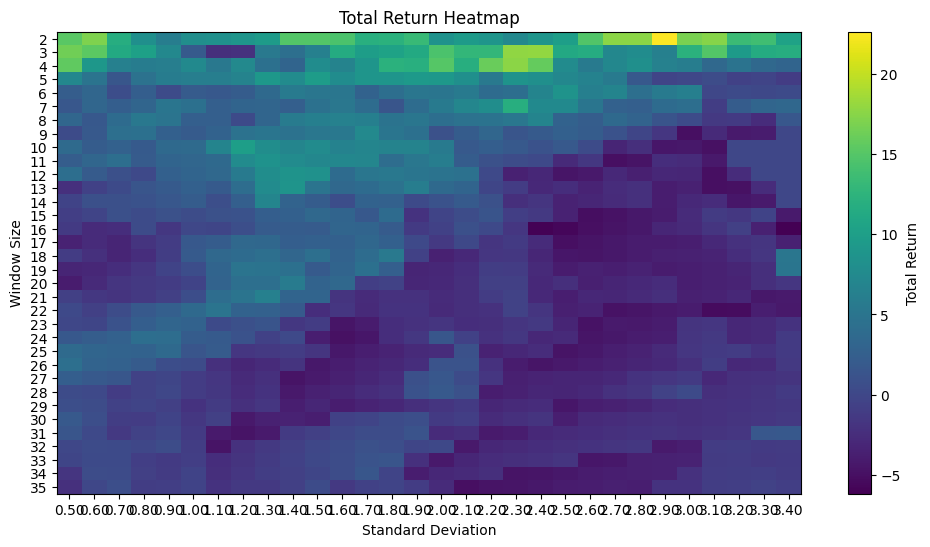

In [17]:

# Parameter ranges to test
window_range = range(2, 36, 1)  # From 10 to 50 in steps of 5
std_range = np.arange(0.5, 3.5, 0.1)  # From 1.5 to 3.0 in steps of 0.25
wait_range = np.arange(0, 1, 1)  # From 0.5 to 1.5 in steps of 0.1

# Run optimization
best_window, best_std, results_df, best_pf = optimize_bollinger_bands(
    df, window_range, std_range, wait_range
)

print(f"\nOptimal Parameters - Window: {best_window}, Std: {best_std:.2f}")
print("\nPerformance Metrics with Optimal Parameters:")
print(best_pf.stats())

# Plot heatmap of Total Return
pivot_table = results_df.pivot(index='window', columns='std', values='total_return')
plt.figure(figsize=(12, 6))
plt.title('Total Return Heatmap')
plt.xlabel('Standard Deviation')
plt.ylabel('Window Size')
plt.imshow(pivot_table, cmap='viridis', aspect='auto')
plt.colorbar(label='Total Return')
plt.xticks(range(len(std_range)), [f"{s:.2f}" for s in std_range])
plt.yticks(range(len(window_range)), window_range)
plt.show()

In [12]:
best_pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '7c97e986-80ee-430f-a22e-4ea133ec7e9d',
              'x': array([datetime.datetime(2025, 3, 17, 0, 0),
                          datetime.datetime(2025, 3, 17, 1, 0),
                          datetime.datetime(2025, 3, 17, 2, 0), ...,
                          datetime.datetime(2025, 4, 1, 12, 0),
                          datetime.datetime(2025, 4, 1, 13, 0),
                          datetime.datetime(2025, 4, 1, 14, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.001538 , 0.0015415, 0.0015356, ..., 0.0015204, 0.0015256, 0.0015094]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 6.50952807e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.62212330e+04, 1.00666207e-01],
                 

In [13]:
bb_strategy_tester(test_df,best_window,best_std).stats()['Total Return [%]']

np.float64(9.677677486131898)

In [14]:
bb_strategy_tester(test_df,best_window,best_std).plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'b4fe849f-788d-4504-bffa-659ea7a75ac3',
              'x': array([datetime.datetime(2025, 4, 1, 15, 0),
                          datetime.datetime(2025, 4, 1, 16, 0),
                          datetime.datetime(2025, 4, 1, 17, 0), ...,
                          datetime.datetime(2025, 4, 17, 3, 0),
                          datetime.datetime(2025, 4, 17, 4, 0),
                          datetime.datetime(2025, 4, 17, 5, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.0015156, 0.0015067, 0.0014952, ..., 0.0015452, 0.0015572, 0.0015609]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 6.72585276e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.69019186e+04, 9.90188536e-02],
                 

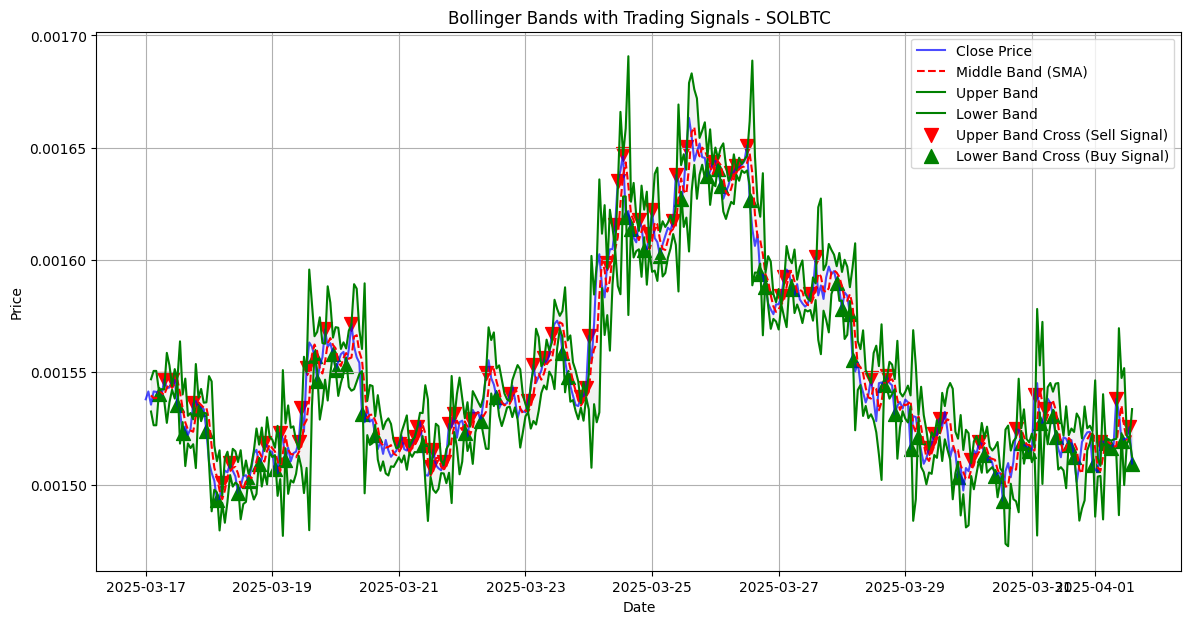

In [16]:
bb_df = calculate_bollinger_bands(df['close'], best_window, best_std)
signals = identify_crossovers(df['close'], bb_df)
trades = generate_trading_signals(df['close'], bb_df, signals)

# Print some trading signals
# print("Sample Trading Signals:")
# print(trades[trades['Position'] != 0].head(10))

# Plot with signals
plot_bollinger_bands_with_signals(df['close'], bb_df, signals, symbol)